In [1]:
import create_data
import kmeans
import voltage
import os
import importlib
import time
import bpf
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [2]:
importlib.reload(create_data)
importlib.reload(kmeans)
importlib.reload(voltage)
importlib.reload(bpf)

<module 'bpf' from '/Users/yoavfreund/projects/VoltageDimentionalReduction/code/bpf.py'>

In [3]:
print("Loading Data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int64)

# data = create_data.Data(np.array(X))

Loading Data...


In [4]:
# MNIST Pre-processing

subDivision = {}
summation = {}
count = {}

print("Sorting and averaging...")

for xi, yi in zip(X, y):
    if yi in summation:
        subDivision[yi].append(np.array(xi))
        summation[yi] += np.array(xi)
        count[yi] += 1
    else:
        subDivision[yi] = [np.array(xi)]
        summation[yi] = np.array(xi)
        count[yi] = 1

Sorting and averaging...


In [5]:
# Kmeans sampling equal points from each of the 10 digits

# """
print("Kmeans...")

points = 1000
k = points // 10
data = []

for yi in range(10):
    print(yi)
    
    partitions = kmeans.Partitions(subDivision[yi])
    partitions.k_means(k, seed=time.time())

    data += list(partitions.centers)

data = create_data.Data(data)
# """

"""
for sd in subDivision:
    print(len(subDivision[sd]))

data = create_data.Data(X)
# """


Kmeans...
0


/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 249, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_darwin()
  File "/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 312, in _count_physical_cores_darwin
    cpu_info = subprocess.run(
  File "/usr/local/Caskroom/miniforge/base/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/usr/local/Caskroom/miniforge/base/lib/python3.9/subprocess.

1
2
3
4
5
6
7
8
9


'\nfor sd in subDivision:\n    print(len(subDivision[sd]))\n\ndata = create_data.Data(X)\n# '

In [6]:
# Create the landmarks

# """
landmarks = []
for yi in range(10):
    landmark = voltage.Landmark(-1, 1)

    ignore = []
    while (landmark.index // k != yi):
        ignore.append(landmark.index)

        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)
 
    landmarks.append(landmark)

print(len(data))
print([l.index for l in landmarks])
# """

"""
landmarks = []
for yi in range(10):
    landmark = voltage.Landmark(-1, 1)

    ignore = []
    while (y[landmark.index] != yi):
        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)

        ignore.append(landmark.index)

    landmarks.append(landmark)

print(len(data))
print([l.index for l in landmarks])
# """

1000
[82, 162, 237, 334, 406, 516, 608, 708, 859, 993]


'\nlandmarks = []\nfor yi in range(10):\n    landmark = voltage.Landmark(-1, 1)\n\n    ignore = []\n    while (y[landmark.index] != yi):\n        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)\n\n        ignore.append(landmark.index)\n\n    landmarks.append(landmark)\n\nprint(len(data))\nprint([l.index for l in landmarks])\n# '

In [7]:
print(type(data))
print(isinstance(data, create_data.Data))

<class 'create_data.Data'>
True


In [8]:
importlib.reload(bpf)

print("Parameter Finding...")

cs = []
pgs = []

param_finder = bpf.BestParameterFinder()
param_finder.setKernelParameter(500)
# param_finder.setResistanceToGround(0.1)

for landmark in landmarks:
     c, p_g = param_finder.bestParameterFinder([landmark], data, minBound=0, maxBound=10, granularity=10, epsilon=0.1, approx=100)
     print(c, p_g)
     cs.append(c)
     pgs.append(p_g)

# print(cs)
# print(pgs)

Parameter Finding...
499.99999999999983 1.0512710963760241
499.99999999999983 1.2214027581601699
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241


In [9]:
print(len(data))
# print(cs)
# print(pgs)
c, p_g = param_finder.bestParameterFinder(landmarks, data, minBound=-10, maxBound=10, granularity=10, epsilon=0.5, approx=100)

1000


In [10]:
print(np.log(c), np.log(p_g))
# c, p_g = cs[1], pgs[1]

6.214608098422191 3.4


In [23]:
voltages = []

for index in range(0, len(landmarks)):
    problem = voltage.Problem(data)
    problem.setKernel(problem.gaussiankernel)
    # problem.setWeights(cs[index])
    problem.setWeights(c)
    problem.addLandmark(landmarks[index])
    # problem.addUniversalGround(pgs[index])
    problem.addUniversalGround(p_g)
    voltages.append(voltage.Solver(problem).approximate_voltages(max_iters=100))

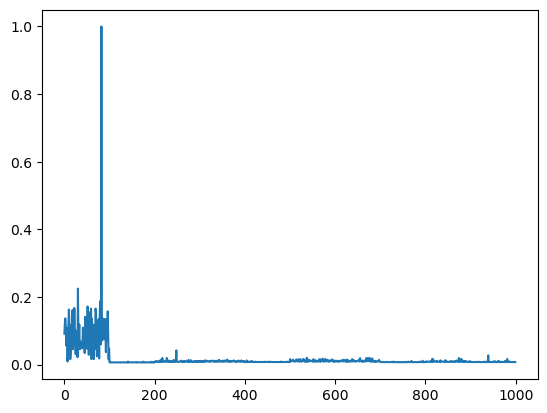

In [25]:
plt.plot(voltages[0])

In [12]:
param_finder.visualizations(voltages, "../inputoutput/matplotfigures/MNIST")

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [13]:
problem = voltage.Problem(data)
problem.setKernel(problem.gaussiankernel)
problem.setWeights(np.exp(6))
# problem.setWeights(c)
problem.addLandmark(landmarks[0])
problem.addUniversalGround(0.1)

temp_volts = voltage.Solver(problem).approximate_voltages(max_iters=100)
print(param_finder.nInfExp(temp_volts))
print(param_finder.expWithStd(temp_volts))
print(np.std(temp_volts))

problem.setWeights(np.exp(10))
temp_volts = voltage.Solver(problem).approximate_voltages(max_iters=100)
print(param_finder.nInfExp(temp_volts))
print(param_finder.expWithStd(temp_volts))
print(np.std(temp_volts))

13.197555205930975
177.09019290235778
0.07452448376521736
12.210712128211874
426.9440495668592
0.028600263056950473


Incorrect predictions: 416/1000
Accuracy: 58.40%
Error Rate: 41.60%


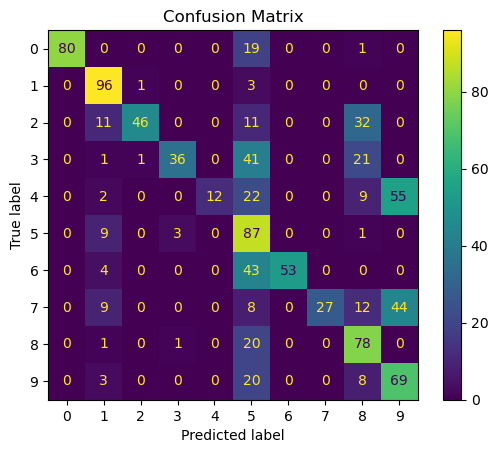

<Figure size 640x480 with 0 Axes>

In [16]:
predicted = np.argmax(voltages, axis=0)
correct = np.repeat(np.arange(10), k)

num_incorrect = np.sum(predicted != correct)

accuracy = np.mean(predicted == correct)
error_rate = 1 - accuracy

print(f"Incorrect predictions: {num_incorrect}/{len(data)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")

cm = confusion_matrix(correct, predicted, labels=np.arange(10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()
plt.clf()

In [32]:
points = np.array(list(map(list, zip(*voltages))))
points= -(0.2)*np.log(points)
print(points.shape)

(1000, 10)


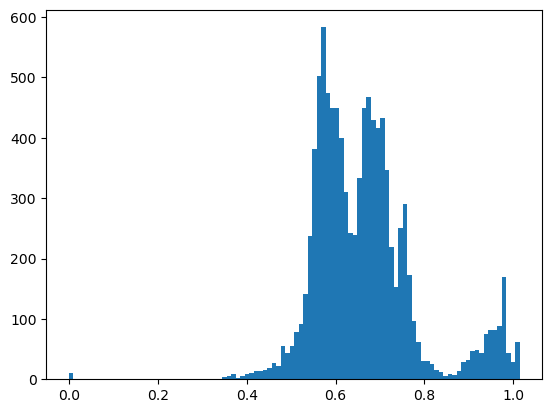

In [33]:
plt.hist(points.flatten(),bins=100);

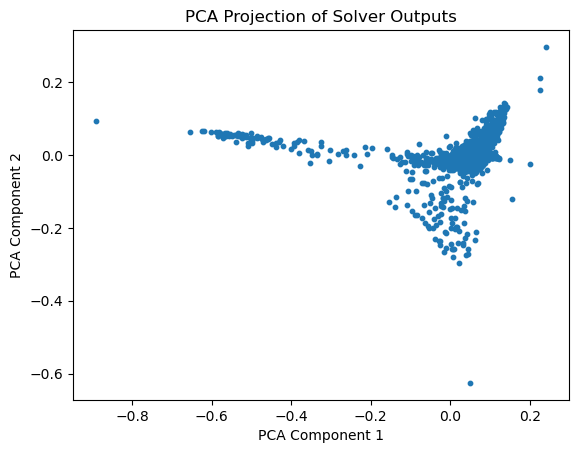

(1000, 2)


<Figure size 640x480 with 0 Axes>

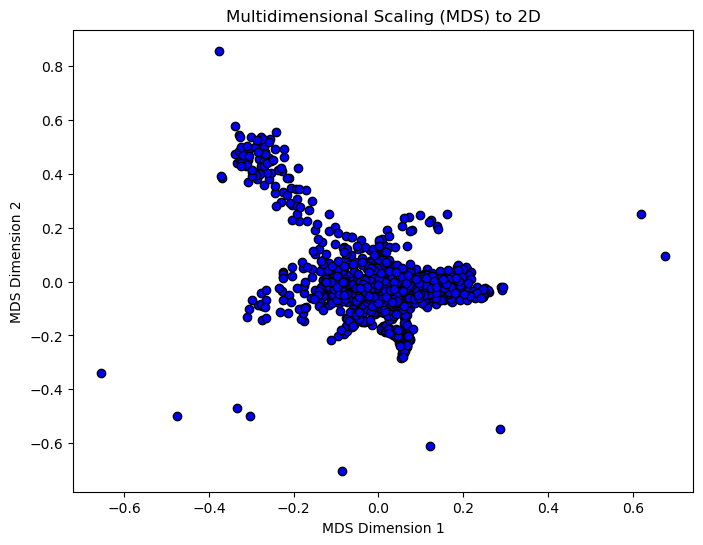

<Figure size 640x480 with 0 Axes>

In [34]:
# PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)

# print(points_2d.shape)

plt.scatter(points_2d[:, 0], points_2d[:, 1], s=10)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Solver Outputs")

plt.show()
# plt.savefig(fileStarter + "_PCA.png")
plt.clf()

# MDS
mds = MDS(n_components=2, random_state=42)
transformed_points = mds.fit_transform(points)

print(transformed_points.shape)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='blue', edgecolors='black')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("Multidimensional Scaling (MDS) to 2D")

# plt.savefig(fileStarter + "_MDS.png")
plt.show()
plt.clf()

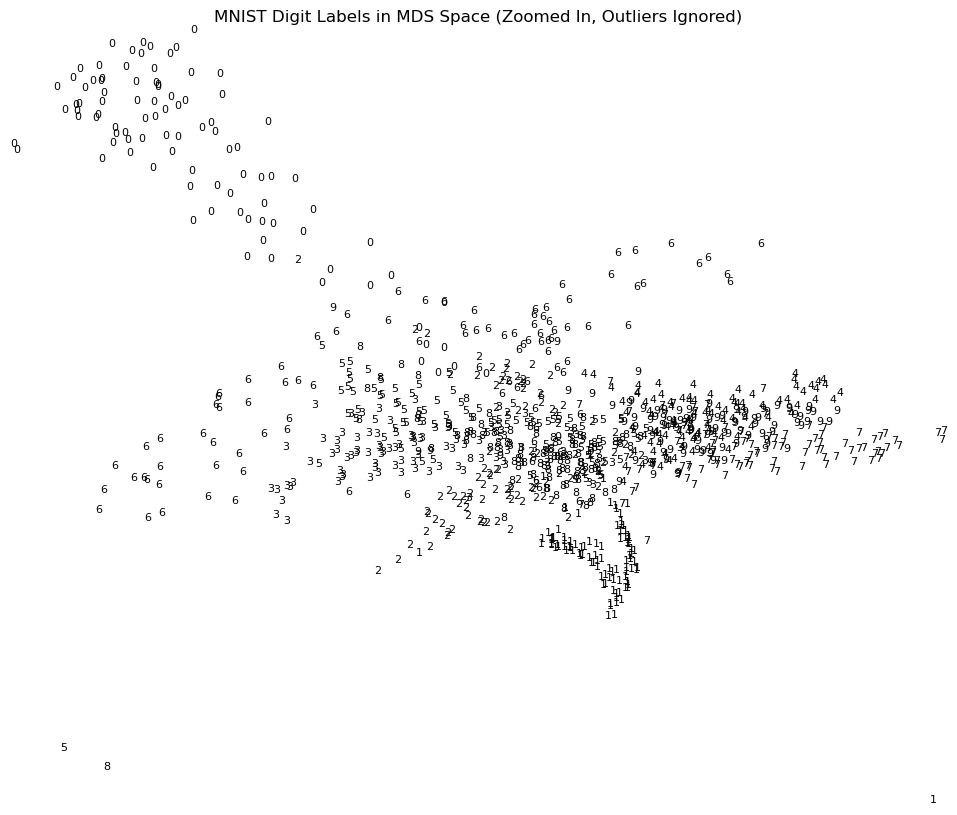

In [36]:
# Step 1: Calculate distances from the mean (or median) of all points
center = np.mean(transformed_points, axis=0)
distances = np.linalg.norm(transformed_points - center, axis=1)

# Step 2: Find the indices of the 10 most distant points
outlier_indices = np.argsort(distances)[-10:]

# Step 3: Get the mask of inliers (non-outliers)
mask = np.ones(len(transformed_points), dtype=bool)
mask[outlier_indices] = False

# Step 4: Get the non-outlier (central cluster) points
inlier_points = transformed_points[mask]

# Plot with zoom-in
fig, ax = plt.subplots(figsize=(12, 10))
for i in np.where(mask)[0]:
    ax.text(transformed_points[i, 0], transformed_points[i, 1], str(correct[i]),
            color='black', fontsize=8, alpha=1,
            ha='center', va='center')

# Set axis limits based on inlier points
ax.set_xlim(inlier_points[:, 0].min(), inlier_points[:, 0].max())
ax.set_ylim(inlier_points[:, 1].min(), inlier_points[:, 1].max())

plt.axis('off')
plt.title("MNIST Digit Labels in MDS Space (Zoomed In, Outliers Ignored)")
plt.show()

In [41]:
def plot_mds_digits(selected_digits, voltages, data, correct, n_outliers=10, alpha_actual=1, percent_size=0.02):
    # Step 0: Filter for selected digits
    voltages = np.array(voltages)
    
    indices = [i for i, label in enumerate(correct) if label in selected_digits]
    filtered_voltages = voltages[np.ix_(selected_digits, indices)]
    points = np.array(list(map(list, zip(*filtered_voltages))))
    points= -(0.2)*np.log(points)

    print(filtered_voltages.shape)
    print(points.shape)

    filtered_data = np.array([data[i] for i in indices])
    filtered_labels = np.array([correct[i] for i in indices])

    print(filtered_data.shape)
    
    # Step 1: Run MDS on voltages    
    mds = MDS(n_components=2, random_state=42)
    transformed_points = mds.fit_transform(points)

    print(transformed_points.shape)
    
    # Step 2: Remove outliers
    center = np.mean(transformed_points, axis=0)
    distances = np.linalg.norm(transformed_points - center, axis=1)
    outlier_indices = np.argsort(distances)[-len(selected_digits):]
    mask = np.ones(len(transformed_points), dtype=bool)
    mask[outlier_indices] = False
    inlier_points = transformed_points[mask]
    
    # Step 3: Plot MNIST images with colored alpha
    fig, ax = plt.subplots(figsize=(12, 10))

    # Assign distinct colors for each digit
    colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
    
    digit_colors = {}

    for i, label in enumerate(selected_digits):
        digit_colors[label] = colors[i]

    x_bound = (inlier_points[:, 0].min(), inlier_points[:, 0].max())
    y_bound = (inlier_points[:, 1].min(), inlier_points[:, 1].max())

    image_size = (x_bound[1] + y_bound[1] - x_bound[0] - y_bound[0]) * percent_size / 2
    
    for i in np.where(mask)[0]:
        alpha_mask = np.clip(filtered_data[i].reshape(28, 28) / 255.0, 0, 1)

        label = filtered_labels[i]
        color = np.array(digit_colors[label])
        
        # Create RGBA image
        rgb_image = np.zeros((28, 28, 4))
        for c in range(3):
            rgb_image[..., c] = color[c]
        rgb_image[..., 3] = alpha_mask * alpha_actual  # Alpha from pixel intensity

        x, y = transformed_points[i]
        ax.imshow(rgb_image, extent=(x - image_size, x + image_size, y - image_size, y + image_size), origin='upper')
    
    ax.set_xlim(x_bound[0] - image_size, x_bound[1] + image_size)
    ax.set_ylim(y_bound[0] - image_size, y_bound[1] + image_size)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    plt.title("MDS Visualization of Digits: " + ", ".join(map(str, selected_digits)))
    plt.show()

(7, 700)
(700, 7)
(700, 784)
(700, 2)


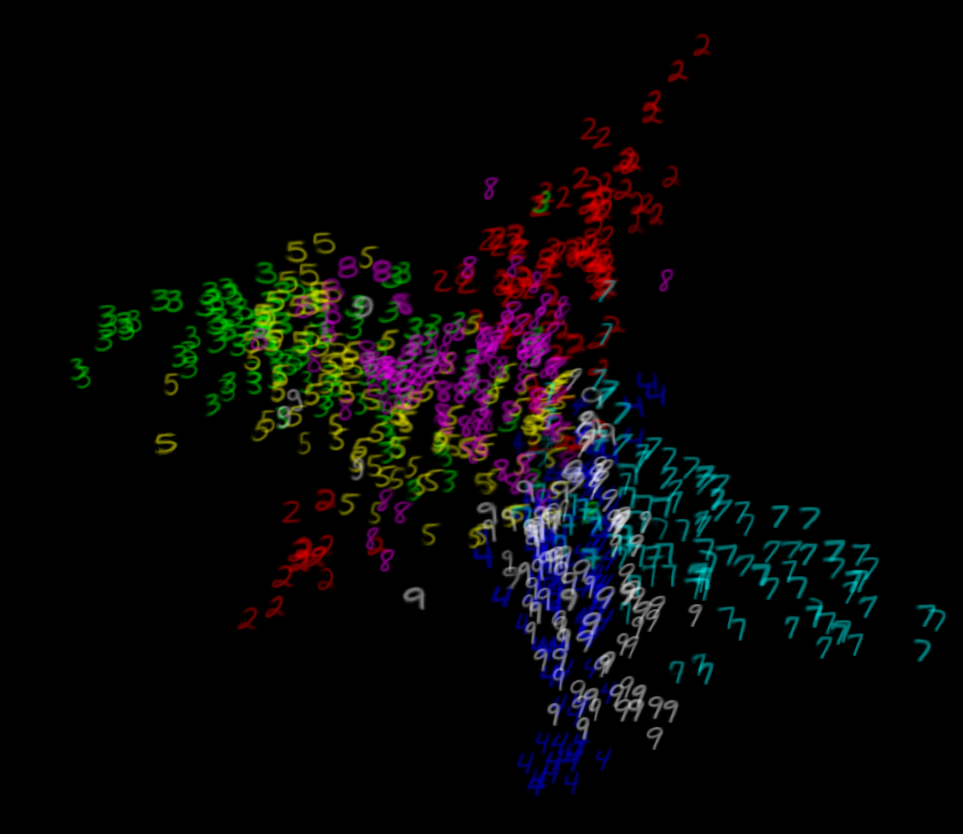

In [42]:
plot_mds_digits([2, 3, 4, 5, 7, 8, 9], voltages, data, correct, alpha_actual=0.5)

(2, 200)
(200, 2)
(200, 784)
(200, 2)


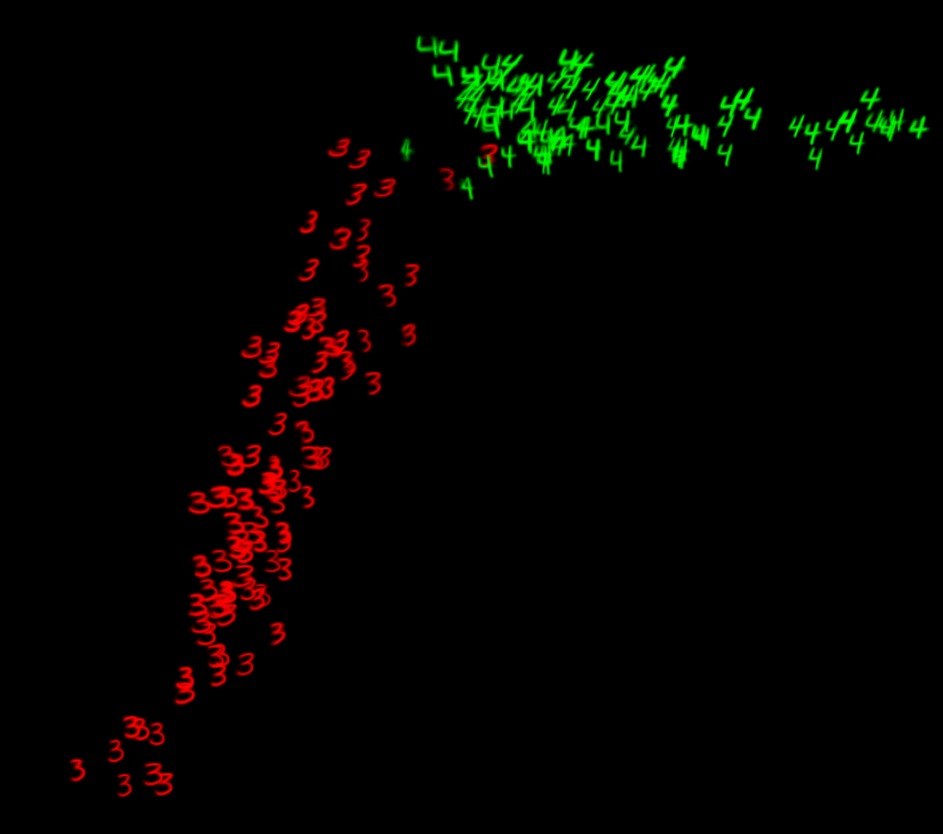

In [43]:
plot_mds_digits([3, 4], voltages, data, correct)

(3, 300)
(300, 3)
(300, 784)
(300, 2)


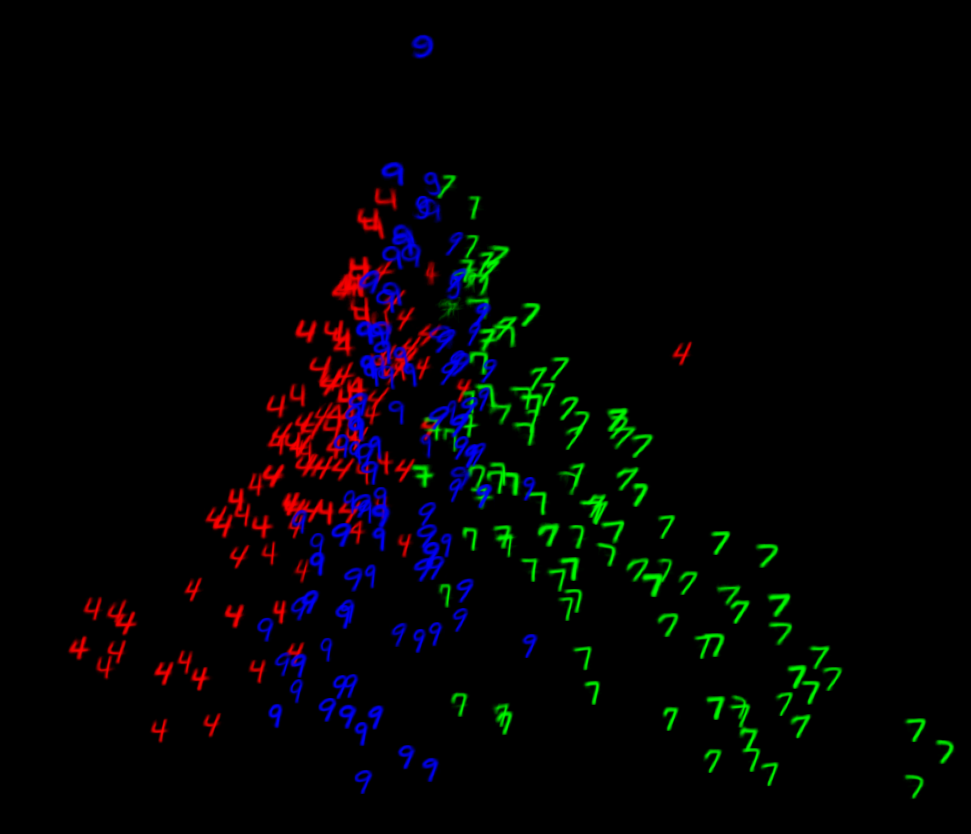

In [44]:
plot_mds_digits([4, 7, 9], voltages, data, correct)